# Feature Store

 - Version tables with Delta
 - Programmatically log Feature Tables

## What is a feature?
- Transformations: Category Encoding
- Context Features: Weekday
- Feature Augmentation: Weather
- Pre-computed Features: Purchase last 7, 14, 21 days

Thinking about it we have Featurization that is compose of Joins, Aggregates, Transforms, etc.

In [0]:
import pandas as pd

white_wine = pd.read_csv("/dbfs/databricks-datasets/wine-quality/winequality-white.csv", sep=";")
red_wine = pd.read_csv("/dbfs/databricks-datasets/wine-quality/winequality-red.csv", sep=";")

Merge the two DataFrames into a single dataset, with a new binary feature "is_red" that indicates whether the wine is red or white.

In [0]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [0]:
data.head()

fixed_acidity 
 volatile_acidity 
 citric_acid 
 residual_sugar 
 chlorides 
 free_sulfur_dioxide 
 total_sulfur_dioxide 
 density 
 pH 
 sulphates 
 alcohol 
 quality 
 is_red 
 
 
 
 
 0 
 7.4 
 0.70 
 0.00 
 1.9 
 0.076 
 11.0 
 34.0 
 0.9978 
 3.51 
 0.56 
 9.4 
 5 
 1 
 
 
 1 
 7.8 
 0.88 
 0.00 
 2.6 
 0.098 
 25.0 
 67.0 
 0.9968 
 3.20 
 0.68 
 9.8 
 5 
 1 
 
 
 2 
 7.8 
 0.76 
 0.04 
 2.3 
 0.092 
 15.0 
 54.0 
 0.9970 
 3.26 
 0.65 
 9.8 
 5 
 1 
 
 
 3 
 11.2 
 0.28 
 0.56 
 1.9 
 0.075 
 17.0 
 60.0 
 0.9980 
 3.16 
 0.58 
 9.8 
 6 
 1 
 
 
 4 
 7.4 
 0.70 
 0.00 
 1.9 
 0.076 
 11.0 
 34.0 
 0.9978 
 3.51 
 0.56 
 9.4 
 5 
 1

## Visualize data

Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, quality.

Out[4]: <AxesSubplot:xlabel='quality', ylabel='Count'>

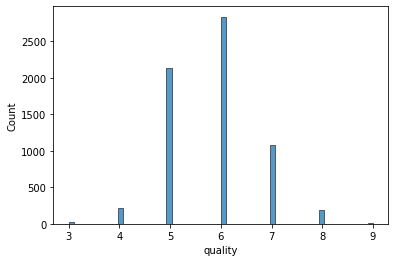

In [0]:
import seaborn as sns
sns.histplot(data.quality, kde=False)

Looks like quality scores are normally distributed between 3 and 9. 

Define a wine as high quality if it has quality >= 7.

In [0]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

Box plots are useful in noticing correlations between features and a binary label.

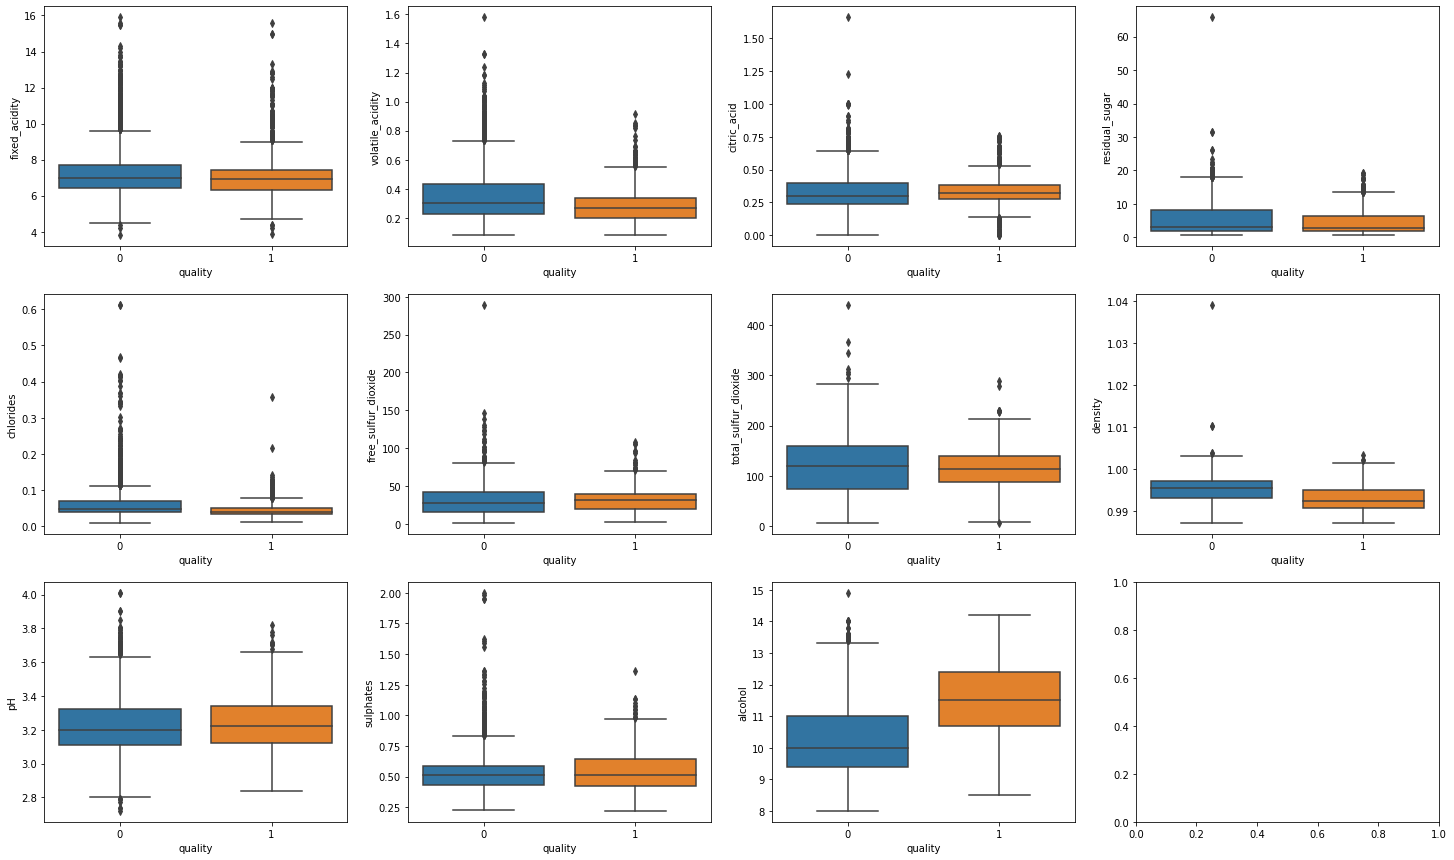

In [0]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality. 

- In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
- In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.

## Preprocess data
Prior to training a model, check for missing values and split the data into training and validation sets.

In [0]:
data = data.reset_index()

In [0]:
data.isna().any()

Out[8]: index                   False
fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
is_red                  False
dtype: bool

There are no missing values.

In [0]:
data.describe()

index 
 fixed_acidity 
 volatile_acidity 
 citric_acid 
 residual_sugar 
 chlorides 
 free_sulfur_dioxide 
 total_sulfur_dioxide 
 density 
 pH 
 sulphates 
 alcohol 
 quality 
 is_red 
 
 
 
 
 count 
 6497.000000 
 6497.000000 
 6497.000000 
 6497.000000 
 6497.000000 
 6497.000000 
 6497.000000 
 6497.000000 
 6497.000000 
 6497.000000 
 6497.000000 
 6497.000000 
 6497.000000 
 6497.000000 
 
 
 mean 
 2042.535632 
 7.215307 
 0.339666 
 0.318633 
 5.443235 
 0.056034 
 30.525319 
 115.744574 
 0.994697 
 3.218501 
 0.531268 
 10.491801 
 0.196552 
 0.246114 
 
 
 std 
 1436.926393 
 1.296434 
 0.164636 
 0.145318 
 4.757804 
 0.035034 
 17.749400 
 56.521855 
 0.002999 
 0.160787 
 0.148806 
 1.192712 
 0.397421 
 0.430779 
 
 
 min 
 0.000000 
 3.800000 
 0.080000 
 0.000000 
 0.600000 
 0.009000 
 1.000000 
 6.000000 
 0.987110 
 2.720000 
 0.220000 
 8.000000 
 0.000000 
 0.000000 
 
 
 25% 
 812.000000 
 6.400000 
 0.230000 
 0.250000 
 1.800000 
 0.038000 
 17.000000 
 77.000000 
 0.992340 
 3.110000 
 0.430000 
 9.500000 
 0.000000 
 0.000000 
 
 
 50% 
 1649.000000 
 7.000000 
 0.290000 
 0.310000 
 3.000000 
 0.047000 
 29.000000 
 118.000000 
 0.994890 
 3.210000 
 0.510000 
 10.300000 
 0.000000 
 0.000000 
 
 
 75% 
 3273.000000 
 7.700000 
 0.400000 
 0.390000 
 8.100000 
 0.065000 
 41.000000 
 156.000000 
 0.996990 
 3.320000 
 0.600000 
 11.300000 
 0.000000 
 0.000000 
 
 
 max 
 4897.000000 
 15.900000 
 1.580000 
 1.660000 
 65.800000 
 0.611000 
 289.000000 
 440.000000 
 1.038980 
 4.010000 
 2.000000 
 14.900000 
 1.000000 
 1.000000

## Feature Store

A <a href="https://docs.databricks.com/applications/machine-learning/feature-store.html#databricks-feature-store" target="_blank">feature store</a> is a **centralized repository of features.** 

It enables feature **sharing and discovery across** your organization and also ensures that the same feature computation code is used for model training and inference.

In [0]:
from databricks import feature_store

fs = feature_store.FeatureStoreClient()

help(fs.create_table)

Help on method create_table in module databricks.feature_store.client:

create_table(name: str, primary_keys: Union[str, List[str]], df: Optional[pyspark.sql.dataframe.DataFrame] = None, *, timestamp_keys: Union[str, List[str], NoneType] = None, partition_columns: Union[str, List[str], NoneType] = None, schema: Optional[pyspark.sql.types.StructType] = None, description: Optional[str] = None, tags: Optional[Dict[str, str]] = None, **kwargs) -> databricks.feature_store.entities.feature_table.FeatureTable method of databricks.feature_store.client.FeatureStoreClient instance
    Create and return a feature table with the given name and primary keys.
    
    The returned feature table has the given name and primary keys.
    Uses the provided ``schema`` or the inferred schema
    of the provided ``df``. If ``df`` is provided, this data will be saved in
    a Delta table. Supported data types for features are: ``IntegerType``, ``LongType``,
    ``FloatType``, ``DoubleType``, ``StringType``,


## Versioning with Delta Tables

Before remember Delta Lake's Key Features:
- ACID transactions --> reliability
- Time travel (data versioning) --> reliability, error recovery, synchronization
- Schema enforcement and evolution --> reliability
- Audit history --> data governance and compliance
- Parquet format + transaction log
- Compatible with Apache Spark API



Let's start by writing to a new Delta Table.

In [0]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert the pandas DataFrame to a Spark DataFrame
psData = spark.createDataFrame(data)

# Write the Spark DataFrame to delta
psData.write.format("delta").mode("overwrite").option("mergeSchema", "true").save("dbfs:/FileStore/wine_quality.delta")

In [0]:
%sql
DESCRIBE HISTORY wine_quality

version timestamp userId userName operation operationParameters job notebook clusterId readVersion isolationLevel isBlindAppend operationMetrics userMetadata engineInfo 2 2024-03-21T05:43:22.000+0000 4955259050321055 darkanita@gmail.com CREATE OR REPLACE TABLE AS SELECT Map(isManaged -> true, description -> Original Wine Quality, partitionBy -> ["quality"], properties -> {}) null List(3999553085601501) 0319-023413-d27nc7x4 1 WriteSerializable false Map(numFiles -> 2, numOutputRows -> 4898, numOutputBytes -> 102690) null Databricks-Runtime/12.2.x-cpu-ml-scala2.12 1 2024-03-21T05:43:14.000+0000 4955259050321055 darkanita@gmail.com CHANGE COLUMN Map(column -> {"name":"index","type":"long","nullable":false,"metadata":{}}) null List(3999553085601501) 0319-023413-d27nc7x4 0 WriteSerializable false Map() null Databricks-Runtime/12.2.x-cpu-ml-scala2.12 0 2024-03-21T05:43:11.000+0000 4955259050321055 darkanita@gmail.com CREATE TABLE AS SELECT Map(isManaged -> true, description -> Original Wine Quality, partitionBy -> ["quality"], properties -> {}) null List(3999553085601501) 0319-023413-d27nc7x4 null WriteSerializable true Map(numFiles -> 0, numOutputRows -> 0, numOutputBytes -> 0) null Databricks-Runtime/12.2.x-cpu-ml-scala2.12

## Create Feature Table

Next, we can create the Feature Table using the **`create_table`** method.

This method takes a few parameters as inputs:
* **`name`** - A feature table name of the form **`<database_name>.<table_name>`**
* **`primary_keys`** - The primary key(s). If multiple columns are required, specify a list of column names.
* **`df`** - Data to insert into this feature table.  The schema of **`data`** will be used as the feature table schema.
* **`schema`** - Feature table schema. Note that either **`schema`** or **`data`** must be provided.
* **`description`** - Description of the feature table
* **`partition_columns`** - Column(s) used to partition the feature table.

In [0]:
display(psData)

index fixed_acidity volatile_acidity citric_acid residual_sugar chlorides free_sulfur_dioxide total_sulfur_dioxide density pH sulphates alcohol quality is_red 0 7.4 0.7 0.0 1.9 0.076 11.0 34.0 0.9978 3.51 0.56 9.4 0 1 1 7.8 0.88 0.0 2.6 0.098 25.0 67.0 0.9968 3.2 0.68 9.8 0 1 2 7.8 0.76 0.04 2.3 0.092 15.0 54.0 0.997 3.26 0.65 9.8 0 1 3 11.2 0.28 0.56 1.9 0.075 17.0 60.0 0.998 3.16 0.58 9.8 0 1 4 7.4 0.7 0.0 1.9 0.076 11.0 34.0 0.9978 3.51 0.56 9.4 0 1 5 7.4 0.66 0.0 1.8 0.075 13.0 40.0 0.9978 3.51 0.56 9.4 0 1 6 7.9 0.6 0.06 1.6 0.069 15.0 59.0 0.9964 3.3 0.46 9.4 0 1 7 7.3 0.65 0.0 1.2 0.065 15.0 21.0 0.9946 3.39 0.47 10.0 1 1 8 7.8 0.58 0.02 2.0 0.073 9.0 18.0 0.9968 3.36 0.57 9.5 1 1 9 7.5 0.5 0.36 6.1 0.071 17.0 102.0 0.9978 3.35 0.8 10.5 0 1 10 6.7 0.58 0.08 1.8 0.097 15.0 65.0 0.9959 3.28 0.54 9.2 0 1 11 7.5 0.5 0.36 6.1 0.071 17.0 102.0 0.9978 3.35 0.8 10.5 0 1 12 5.6 0.615 0.0 1.6 0.089 16.0 59.0 0.9943 3.58 0.52 9.9 0 1 13 7.8 0.61 0.29 1.6 0.114 9.0 29.0 0.9974 3.26 1.56 9.1 0 1 14 8.9 0.62 0.18 3.8 0.176 52.0 145.0 0.9986 3.16 0.88 9.2 0 1 15 8.9 0.62 0.19 3.9 0.17 51.0 148.0 0.9986 3.17 0.93 9.2 0 1 16 8.5 0.28 0.56 1.8 0.092 35.0 103.0 0.9969 3.3 0.75 10.5 1 1 17 8.1 0.56 0.28 1.7 0.368 16.0 56.0 0.9968 3.11 1.28 9.3 0 1 18 7.4 0.59 0.08 4.4 0.086 6.0 29.0 0.9974 3.38 0.5 9.0 0 1 19 7.9 0.32 0.51 1.8 0.341 17.0 56.0 0.9969 3.04 1.08 9.2 0 1 20 8.9 0.22 0.48 1.8 0.077 29.0 60.0 0.9968 3.39 0.53 9.4 0 1 21 7.6 0.39 0.31 2.3 0.082 23.0 71.0 0.9982 3.52 0.65 9.7 0 1 22 7.9 0.43 0.21 1.6 0.106 10.0 37.0 0.9966 3.17 0.91 9.5 0 1 23 8.5 0.49 0.11 2.3 0.084 9.0 67.0 0.9968 3.17 0.53 9.4 0 1 24 6.9 0.4 0.14 2.4 0.085 21.0 40.0 0.9968 3.43 0.63 9.7 0 1 25 6.3 0.39 0.16 1.4 0.08 11.0 23.0 0.9955 3.34 0.56 9.3 0 1 26 7.6 0.41 0.24 1.8 0.08 4.0 11.0 0.9962 3.28 0.59 9.5 0 1 27 7.9 0.43 0.21 1.6 0.106 10.0 37.0 0.9966 3.17 0.91 9.5 0 1 28 7.1 0.71 0.0 1.9 0.08 14.0 35.0 0.9972 3.47 0.55 9.4 0 1 29 7.8 0.645 0.0 2.0 0.082 8.0 16.0 0.9964 3.38 0.59 9.8 0 1 30 6.7 0.675 0.07 2.4 0.089 17.0 82.0 0.9958 3.35 0.54 10.1 0 1 31 6.9 0.685 0.0 2.5 0.105 22.0 37.0 0.9966 3.46 0.57 10.6 0 1 32 8.3 0.655 0.12 2.3 0.083 15.0 113.0 0.9966 3.17 0.66 9.8 0 1 33 6.9 0.605 0.12 10.7 0.073 40.0 83.0 0.9993 3.45 0.52 9.4 0 1 34 5.2 0.32 0.25 1.8 0.103 13.0 50.0 0.9957 3.38 0.55 9.2 0 1 35 7.8 0.645 0.0 5.5 0.086 5.0 18.0 0.9986 3.4 0.55 9.6 0 1 36 7.8 0.6 0.14 2.4 0.086 3.0 15.0 0.9975 3.42 0.6 10.8 0 1 37 8.1 0.38 0.28 2.1 0.066 13.0 30.0 0.9968 3.23 0.73 9.7 1 1 38 5.7 1.13 0.09 1.5 0.172 7.0 19.0 0.994 3.5 0.48 9.8 0 1 39 7.3 0.45 0.36 5.9 0.074 12.0 87.0 0.9978 3.33 0.83 10.5 0 1 40 7.3 0.45 0.36 5.9 0.074 12.0 87.0 0.9978 3.33 0.83 10.5 0 1 41 8.8 0.61 0.3 2.8 0.088 17.0 46.0 0.9976 3.26 0.51 9.3 0 1 42 7.5 0.49 0.2 2.6 0.332 8.0 14.0 0.9968 3.21 0.9 10.5 0 1 43 8.1 0.66 0.22 2.2 0.069 9.0 23.0 0.9968 3.3 1.2 10.3 0 1 44 6.8 0.67 0.02 1.8 0.05 5.0 11.0 0.9962 3.48 0.52 9.5 0 1 45 4.6 0.52 0.15 2.1 0.054 8.0 65.0 0.9934 3.9 0.56 13.1 0 1 46 7.7 0.935 0.43 2.2 0.114 22.0 114.0 0.997 3.25 0.73 9.2 0 1 47 8.7 0.29 0.52 1.6 0.113 12.0 37.0 0.9969 3.25 0.58 9.5 0 1 48 6.4 0.4 0.23 1.6 0.066 5.0 12.0 0.9958 3.34 0.56 9.2 0 1 49 5.6 0.31 0.37 1.4 0.074 12.0 96.0 0.9954 3.32 0.58 9.2 0 1 50 8.8 0.66 0.26 1.7 0.074 4.0 23.0 0.9971 3.15 0.74 9.2 0 1 51 6.6 0.52 0.04 2.2 0.069 8.0 15.0 0.9956 3.4 0.63 9.4 0 1 52 6.6 0.5 0.04 2.1 0.068 6.0 14.0 0.9955 3.39 0.64 9.4 0 1 53 8.6 0.38 0.36 3.0 0.081 30.0 119.0 0.997 3.2 0.56 9.4 0 1 54 7.6 0.51 0.15 2.8 0.11 33.0 73.0 0.9955 3.17 0.63 10.2 0 1 55 7.7 0.62 0.04 3.8 0.084 25.0 45.0 0.9978 3.34 0.53 9.5 0 1 56 10.2 0.42 0.57 3.4 0.07 4.0 10.0 0.9971 3.04 0.63 9.6 0 1 57 7.5 0.63 0.12 5.1 0.111 50.0 110.0 0.9983 3.26 0.77 9.4 0 1 58 7.8 0.59 0.18 2.3 0.076 17.0 54.0 0.9975 3.43 0.59 10.0 0 1 59 7.3 0.39 0.31 2.4 0.074 9.0 46.0 0.9962 3.41 0.54 9.4 0 1 60 8.8 0.4 0.4 2.2 0.079 19.0 52.0 0.998 3.44 0.64 9.2 0 1 61 7.7 0.69 0.49 1.8 0.115 20.0 112.0 0.9968 3.21 0.71 9.3 0 1 62 7.5 0.52 0.16 1.9 0.085 12.0 35.0 0.996

In [0]:
# Drop duplicate rows based on the key combination
psData = psData.dropDuplicates(["index"])

fs.create_table(
    name="wine_quality",
    df=psData,
    partition_columns=["quality"],
    primary_keys=["index"],  # Add the primary key column(s) here
    description="Original Wine Quality"
)

2024/03/21 11:28:41 WARNING databricks.feature_store._compute_client._compute_client: The feature table "wsdb_training.default.wine_quality" already exists. Use "FeatureStoreClient.write_table" API to write to the feature table.
/databricks/python/lib/python3.9/site-packages/databricks/feature_store/entities/_feature_store_object.py:8: FutureWarning: ``databricks.feature_store.entities.feature_table.FeatureTable.keys`` is deprecated since v0.3.6. This method will be removed in a future release. Use ``FeatureTable.primary_keys`` instead.
  yield prop, self.__getattribute__(prop)


Out[14]: <FeatureTable: keys=['index'], tags={}>

We can also look at the metadata of the feature store via the FeatureStore client by using **`get_table()`**.

In [0]:
print(f"Feature table description : {fs.get_table('wine_quality').description}")

Feature table description : Original Wine Quality


In [0]:
# Display most recent table
feature_df = fs.read_table(name='wine_quality')
display(feature_df)

index fixed_acidity volatile_acidity citric_acid residual_sugar chlorides free_sulfur_dioxide total_sulfur_dioxide density pH sulphates alcohol quality is_red 474 10.5 0.28 0.51 1.7 0.08 10.0 24.0 0.9982 3.2 0.89 9.4 0 1 29 7.8 0.645 0.0 2.0 0.082 8.0 16.0 0.9964 3.38 0.59 9.8 0 1 26 7.6 0.41 0.24 1.8 0.08 4.0 11.0 0.9962 3.28 0.59 9.5 0 1 964 8.5 0.47 0.27 1.9 0.058 18.0 38.0 0.99518 3.16 0.85 11.1 0 1 2040 6.7 0.3 0.45 10.6 0.032 56.0 212.0 0.997 3.22 0.59 9.5 0 0 1697 6.9 0.18 0.3 2.0 0.038 39.0 190.0 0.9914 3.32 0.37 12.2 0 0 2509 8.0 0.27 0.57 10.4 0.053 18.0 134.0 0.99732 3.12 0.68 9.0 0 0 1677 7.3 0.23 0.37 1.8 0.032 60.0 156.0 0.992 3.11 0.35 11.1 0 0 1950 8.0 0.25 0.13 17.2 0.036 49.0 219.0 0.9996 2.96 0.46 9.7 0 0 2453 6.3 0.2 0.26 1.6 0.027 36.0 141.0 0.99268 3.53 0.56 10.8 0 0 3091 6.3 0.28 0.47 11.2 0.04 61.0 183.0 0.99592 3.12 0.51 9.5 0 0 2250 9.2 0.34 0.54 17.3 0.06 46.0 235.0 1.00182 3.08 0.61 8.8 0 0 2214 7.1 0.26 0.3 2.0 0.031 13.0 128.0 0.9917 3.19 0.49 11.4 0 0 2529 6.6 0.42 0.13 12.8 0.044 26.0 158.0 0.99772 3.24 0.47 9.0 0 0 1806 7.6 0.38 0.2 3.4 0.046 9.0 116.0 0.9944 3.15 0.41 9.4 0 0 4590 6.4 0.33 0.3 7.2 0.041 42.0 168.0 0.99331 3.22 0.49 11.1 0 0 4894 6.6 0.32 0.36 8.0 0.047 57.0 168.0 0.9949 3.15 0.46 9.6 0 0 3506 7.5 0.33 0.28 4.9 0.042 21.0 155.0 0.99385 3.36 0.57 10.9 0 0 558 10.9 0.53 0.49 4.6 0.118 10.0 17.0 1.0002 3.07 0.56 11.7 0 1 541 9.5 0.46 0.49 6.3 0.064 5.0 17.0 0.9988 3.21 0.73 11.0 0 1 65 7.2 0.725 0.05 4.65 0.086 4.0 11.0 0.9962 3.41 0.39 10.9 0 1 1277 7.0 0.69 0.0 1.9 0.114 3.0 10.0 0.99636 3.35 0.6 9.7 0 1 1258 6.8 0.64 0.0 2.7 0.123 15.0 33.0 0.99538 3.44 0.63 11.3 0 1 1224 12.6 0.39 0.49 2.5 0.08 8.0 20.0 0.9992 3.07 0.82 10.3 0 1 1360 9.2 0.54 0.31 2.3 0.112 11.0 38.0 0.99699 3.24 0.56 10.9 0 1 191 6.4 0.37 0.25 1.9 0.074 21.0 49.0 0.9974 3.57 0.62 9.8 0 1 418 11.9 0.38 0.51 2.0 0.121 7.0 20.0 0.9996 3.24 0.76 10.4 0 1 2895 6.4 0.44 0.26 2.0 0.054 20.0 180.0 0.9952 3.58 0.57 10.0 0 0 2906 6.6 0.26 0.46 6.9 0.047 59.0 183.0 0.99594 3.2 0.45 9.3 0 0 1840 6.9 0.18 0.33 1.0 0.054 24.0 164.0 0.9926 3.42 0.51 10.5 0 0 2941 7.2 0.3 0.3 8.7 0.022 14.0 111.0 0.99576 3.11 0.61 10.6 0 0 3009 6.5 0.2 0.5 18.1 0.054 50.0 221.0 0.99941 2.94 0.64 8.8 0 0 3015 7.2 0.32 0.3 8.25 0.02 14.0 104.0 0.99362 2.99 0.44 11.4 0 0 2173 7.6 0.32 0.58 16.75 0.05 43.0 163.0 0.9999 3.15 0.54 9.2 0 0 3106 7.6 0.27 0.52 3.2 0.043 28.0 152.0 0.99129 3.02 0.53 11.4 0 0 3061 6.2 0.25 0.54 7.0 0.046 58.0 176.0 0.99454 3.19 0.7 10.4 0 0 2812 6.7 0.16 0.34 1.6 0.026 27.0 109.0 0.9934 3.34 0.58 10.1 0 0 3806 7.0 0.39 0.21 10.7 0.098 13.0 91.0 0.99657 3.03 0.47 9.3 0 0 4371 7.0 0.23 0.28 2.7 0.053 16.0 92.0 0.99372 3.18 0.56 9.3 0 0 3280 6.4 0.15 0.29 1.8 0.044 21.0 115.0 0.99166 3.1 0.38 10.2 0 0 3800 8.1 0.2 0.3 1.3 0.036 7.0 49.0 0.99242 2.99 0.73 10.3 0 0 4126 6.3 0.18 0.22 5.6 0.047 45.0 147.0 0.99383 3.09 0.54 10.0 0 0 1551 7.1 0.67 0.0 2.3 0.083 18.0 27.0 0.99768 3.44 0.54 9.4 0 1 293 6.9 0.36 0.25 2.4 0.098 5.0 16.0 0.9964 3.41 0.6 10.1 0 1 1371 7.5 0.58 0.56 3.1 0.153 5.0 14.0 0.99476 3.21 1.03 11.6 0 1 222 6.8 0.61 0.04 1.5 0.057 5.0 10.0 0.99525 3.42 0.6 9.5 0 1 270 7.9 0.545 0.06 4.0 0.087 27.0 61.0 0.9965 3.36 0.67 10.7 0 1 730 9.5 0.55 0.66 2.3 0.387 12.0 37.0 0.9982 3.17 0.67 9.6 0 1 1145 8.2 0.2 0.43 2.5 0.076 31.0 51.0 0.99672 3.53 0.81 10.4 0 1 1127 6.3 0.76 0.0 2.9 0.072 26.0 52.0 0.99379 3.51 0.6 11.5 0 1 1409 6.0 0.51 0.0 2.1 0.064 40.0 54.0 0.995 3.54 0.93 10.7 0 1 2517 7.3 0.51 0.29 11.3 0.034 61.0 224.0 0.99683 3.14 0.56 9.5 0 0 2909 6.2 0.18 0.3 1.0 0.031 23.0 73.0 0.99032 3.23 0.52 11.3 0 0 2989 6.2 0.16 0.32 1.1 0.036 74.0 184.0 0.99096 3.22 0.41 11.0 0 0 2184 6.4 0.33 0.24 9.8 0.041 29.0 109.0 0.9956 3.29 0.47 10.1 0 0 2570 6.6 0.24 0.28 1.8 0.028 39.0 132.0 0.99182 3.34 0.46 11.4 0 0 3937 6.5 0.36 0.36 6.7 0.185 51.5 151.0 0.99528 3.17 0.42 9.3 0 0 3845 6.4 0.32 0.23 16.2 0.055 36.0 176.0 0.9986 3.26 0.54 9.1 0 0 4551 7.0 0.23 0.32 1.8 0.048 25.0 113.0 0.9915 3.11 0.47 11.1 0 0 3704 7.5 0.

# Experiment Tracking

The machine learning life cycle involves training multiple algorithms using different hyperparameters and libraries, all with different performance results and trained models.  This lesson explores tracking those experiments to organize the machine learning life cycle.

Over the course of the machine learning life cycle...<br><br>

* Data scientists test many different models
* Using various libraries
* Each with different hyperparameters

Tracking these various results poses an organizational challenge, including... <br><br>

* Storing experiments
* Results
* Models
* Supplementary artifacts
* Code
* Data snapshots

### Tracking Experiments with MLflow

MLflow Tracking is...<br>

* a logging API specific for machine learning
* agnostic to libraries and environments that do the training
* organized around the concept of **runs**, which are executions of data science code
* runs are aggregated into **experiments** where many runs can be a part of a given experiment
* An MLflow server can host many experiments.

Each run can record the following information:<br>

* **Parameters:** Key-value pairs of input parameters such as the number of trees in a random forest model
* **Metrics:** Evaluation metrics such as RMSE or Area Under the ROC Curve
* **Artifacts:** Arbitrary output files in any format.  This can include images, pickled models, and data files
* **Source:** The code that originally ran the experiment

Experiments can be tracked using libraries in Python, R, and Java as well as by using the CLI and REST calls

### Experiment Logging and UI

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=123)
X_train = train.drop(["quality"], axis=1)
X_test = test.drop(["quality"], axis=1)
y_train = train.quality
y_test = test.quality



**Navigate to the MLflow UI by clicking on the `Experiment` button on the top of the screen.**

Every Python notebook in a Databricks Workspace has its own experiment. When you use MLflow in a notebook, it records runs in the notebook experiment. A notebook experiment shares the same name and ID as its corresponding notebook.


Log a basic experiment by doing the following:<br><br>

1. Start an experiment using **`mlflow.start_run()`** and passing it a name for the run
2. Train your model
3. Log the model using **`mlflow.sklearn.log_model()`**
4. Log the model error using **`mlflow.log_metric()`**
5. Print out the run id using **`run.info.run_id`**

## Build a baseline model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn. It uses MLflow to keep track of the model accuracy, and to save the model for later use.

In [0]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn

import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

import cloudpickle
import time

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)

  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

/databricks/python/lib/python3.9/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Examine the learned feature importances output by the model as a sanity-check.

In [0]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

importance 
 
 
 
 
 alcohol 
 0.174671 
 
 
 density 
 0.101780 
 
 
 volatile_acidity 
 0.089591 
 
 
 free_sulfur_dioxide 
 0.080298 
 
 
 index 
 0.080151 
 
 
 sulphates 
 0.077463 
 
 
 total_sulfur_dioxide 
 0.074422 
 
 
 chlorides 
 0.068680 
 
 
 residual_sugar 
 0.067126 
 
 
 pH 
 0.064492 
 
 
 citric_acid 
 0.063006 
 
 
 fixed_acidity 
 0.055588 
 
 
 is_red 
 0.002734

As illustrated by the boxplots shown previously, both alcohol and density are important in predicting quality.

You logged the Area Under the ROC Curve (AUC) to MLflow. Click **Experiment** at the upper right to display the Experiment Runs sidebar. 

The model achieved an AUC of 0.89. 

A random classifier would have an AUC of 0.5, and higher AUC values are better. For more information, see [Receiver Operating Characteristic Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

#### Register the model in MLflow Model Registry

By registering this model in Model Registry, you can easily reference the model from anywhere within Databricks.

The following section shows how to do this programmatically, but you can also register a model using the UI. See "Create or register a model using the UI" ([AWS](https://docs.databricks.com/applications/machine-learning/manage-model-lifecycle/index.html#create-or-register-a-model-using-the-ui)|[Azure](https://docs.microsoft.com/azure/databricks/applications/machine-learning/manage-model-lifecycle/index#create-or-register-a-model-using-the-ui)|[GCP](https://docs.gcp.databricks.com/applications/machine-learning/manage-model-lifecycle/index.html#create-or-register-a-model-using-the-ui)).

In [0]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id

In [0]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = "wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Successfully registered model 'wine_quality'.
2024/03/21 11:45:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: wine_quality, version 1
Created version '1' of model 'wine_quality'.


You should now see the model in the Models page. To display the Models page, click the Models icon in the left sidebar. 

Next, transition this model to production and load it into this notebook from Model Registry.

In [0]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

Out[25]: <ModelVersion: creation_timestamp=1711021526862, current_stage='Production', description='', last_updated_timestamp=1711021684130, name='wine_quality', run_id='6bea7f22e122470ea19f4df03bb45b5c', run_link='', source='dbfs:/databricks/mlflow-tracking/3999553085601501/6bea7f22e122470ea19f4df03bb45b5c/artifacts/random_forest_model', status='READY', status_message='', tags={}, user_id='4955259050321055', version='1'>

The Models page now shows the model version in stage "Production".

You can now refer to the model using the path "models:/wine_quality/production".

##Experiment with a new model

The random forest model performed well even without hyperparameter tuning.

The following code uses the xgboost library to train a more accurate model. It runs a parallel hyperparameter sweep to train multiple
models in parallel, using Hyperopt and SparkTrials. As before, the code tracks the performance of each parameter configuration with MLflow.

In [0]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb

search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}

def train_model(params):
  # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    test = xgb.DMatrix(data=X_test, label=y_test)
    # Pass in the test set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(test, "test")], early_stopping_rounds=50)
    predictions_test = booster.predict(test)
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_metric('auc', auc_score)

    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "model", signature=signature)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# A reasonable value for parallelism is the square root of max_evals.
spark_trials = SparkTrials(parallelism=10)

# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=96,
    trials=spark_trials, 
  )

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


 38%|███▊      | 36/96 [11:24<17:05, 17.09s/trial, best loss: -0.9325139223771002]

#### Use MLflow to view the results
Open up the Experiment Runs sidebar to see the MLflow runs. Click on Date next to the down arrow to display a menu, and select 'auc' to display the runs sorted by the auc metric. The highest auc value is 0.91. You beat the baseline!

MLflow tracks the parameters and performance metrics of each run. Click the External Link icon <img src="https://docs.databricks.com/_static/images/icons/external-link.png"/> at the top of the Experiment Runs sidebar to navigate to the MLflow Runs Table.

Now investigate how the hyperparameter choice correlates with AUC. Click the "+" icon to expand the parent run, then select all runs except the parent, and click "Compare". Select the Parallel Coordinates Plot.

The Parallel Coordinates Plot is useful in understanding the impact of parameters on a metric. You can drag the pink slider bar at the upper right corner of the plot to highlight a subset of AUC values and the corresponding parameter values. The plot below highlights the highest AUC values:

<img src="https://docs.databricks.com/_static/images/mlflow/end-to-end-example/parallel-coordinates-plot.png"/>

Notice that all of the top performing runs have a low value for reg_lambda and learning_rate. 

You could run another hyperparameter sweep to explore even lower values for these parameters. For simplicity, that step is not included in this example.


You used MLflow to log the model produced by each hyperparameter configuration. The following code finds the best performing run and saves the model to Model Registry.


In [0]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

#### Update the production `wine_quality` model in MLflow Model Registry

Earlier, you saved the baseline model to Model Registry with the name `wine_quality`. Now that you have a created a more accurate model, update `wine_quality`.

In [0]:
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Click **Models** in the left sidebar to see that the `wine_quality` model now has two versions. 

The following code promotes the new version to production.


In [0]:
# Archive the old model version
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Archived"
)

# Promote the new model version to Production
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version.version,
  stage="Production"
)

%md Clients that call load_model now receive the new model.

In [0]:
# This code is the same as the last block of "Building a Baseline Model". No change is required for clients to get the new model!
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

##Batch inference

There are many scenarios where you might want to evaluate a model on a corpus of new data. For example, you may have a fresh batch of data, or may need to compare the performance of two models on the same corpus of data.

The following code evaluates the model on data stored in a Delta table, using Spark to run the computation in parallel.

In [0]:
# To simulate a new corpus of data, save the existing X_train data to a Delta table. 
# In the real world, this would be a new batch of data.
spark_df = spark.createDataFrame(X_train)
# Replace <username> with your username before running this cell.
table_path = "dbfs:/darkanita@gmail.com/delta/wine_data"
# Delete the contents of this path in case this cell has already been run
dbutils.fs.rm(table_path, True)
spark_df.write.format("delta").save(table_path)

Load the model into a Spark UDF, so it can be applied to the Delta table.

In [0]:
import mlflow.pyfunc

apply_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{model_name}/production")

In [0]:
# Read the "new data" from Delta
new_data = spark.read.format("delta").load(table_path)

In [0]:
display(new_data)

In [0]:
from pyspark.sql.functions import struct

# Apply the model to the new data
udf_inputs = struct(*(X_train.columns.tolist()))

new_data = new_data.withColumn(
  "prediction",
  apply_model_udf(udf_inputs)
)

In [0]:
# Each row now has an associated prediction. Note that the xgboost function does not output probabilities by default, so the predictions are not limited to the range [0, 1].
display(new_data)

## Model serving

To productionize the model for low latency predictions, use MLflow Model Serving ([AWS](https://docs.databricks.com/applications/mlflow/model-serving.html)|[Azure](https://docs.microsoft.com/azure/databricks/applications/mlflow/model-serving)|[GCP](https://docs.gcp.databricks.com/applications/mlflow/model-serving.html)) to deploy the model to an endpoint.

The following code illustrates how to issue requests using a REST API to get predictions from the deployed model.

You need a Databricks token to issue requests to your model endpoint. You can generate a token from the User Settings page (click Settings in the left sidebar). Copy the token into the next cell.

In [0]:
import os
os.environ["DATABRICKS_TOKEN"] = "<YOUR_TOKEN>"

Click **Models** in the left sidebar and navigate to the registered wine model. Click the serving tab, and then click **Enable Serving**.

Then, under **Call The Model**, click the **Python** button to display a Python code snippet to issue requests. Copy the code into this notebook. It should look similar to the code in the next cell. 

You can use the token to make these requests from outside Databricks notebooks as well.

In [0]:
# Replace with code snippet from the model serving page
import os
import requests
import pandas as pd

def score_model(dataset: pd.DataFrame):
  url = 'https://<DATABRICKS_URL>/model/wine_quality/Production/invocations'
  headers = {'Authorization': f'Bearer {os.environ.get("DATABRICKS_TOKEN")}'}
  data_json = dataset.to_dict(orient='split')
  response = requests.request(method='POST', headers=headers, url=url, json=data_json)
  if response.status_code != 200:
    raise Exception(f'Request failed with status {response.status_code}, {response.text}')
  return response.json()